# Machine Learning Nanodegree

## Capstone Project:  Sberbank Housing Price Prediction

## I.  Definition

### Project Overview

The first project for this course was predicting housing prices in Boston based on a simple feature set.  This project will build on some of the intuition that was built while completing that project.

The website [Kaggle](https://www.kaggle.com) is currently hosting a competition that requires implementation of regression techniques like those used in the Boston housing prediction project.  Sberbank, the Russian bank, along with Kaggle, is hosting a competition to predict Russian housing prices based on a dataset rich in features.  According to the [project introduction page](https://www.kaggle.com/c/sberbank-russian-housing-market), the Russian housing market is relatively stable when compared to the more volatile Russian economy, as a whole.  Having an accurate predictor would help to assure both investors and prospective property owners that they are making wise choices in how they invest in Russian real estate despite other potentially worrying economic indicators.

### Problem Statement

Kaggle has provided a full dataset broken into training and test datasets.  This dataset provides features from which a regression model will be used to predict housing prices based on the values of these features.  A standard regression technique such as the one used for the Boston housing prediction project will most likely not perform well on the larger, more nuanced feature set that will be used for this project.  A more flexible learner is needed.  The package [XGBoost](http://xgboost.readthedocs.io/en/latest) is a fully integrated, flexible framework for performing gradient boosting regression using multiple simple learners, such as decision trees.  The combination of simple learners into a more complex single learner has been very successful (see [this]()).  The reason XGBoost is chosen as the starting point is its [success](https://github.com/dmlc/xgboost/tree/master/demo#machine-learning-challenge-winning-solutions) in previous machine learning competitions.

The solution to this project has two parts:  (1) tuning a regressor to minimize the prediction error of housing prices on validation data extracted from the training set provided and (2) predicting prices on the Kaggle-provided test set using regressors developed during the tuning process.  The prediction data on the test set will be submitted to Kaggle for internal computation of a public score.  The public score is used to rank solutions and will be used as a sanity check on the algorithm's performance.  The desired public score is as close to 0 as possible; lower scores are better than higher ones.

### Metrics

The primary metric here, as in most regression problems, is error on a test set with known output.  The error metric used for optimization is the negative of the [mean squared error](https://en.wikipedia.org/wiki/Mean_squared_error); this provides a strong estimate of how well matched predictions are to actual observations.  Since the error is averaged over all elements of a dataset (training or validation), this provides a quantitative assessment of model quality. The negative is chosen on account of the `sklearn` protocol where the negative is used in a maximization scheme; that is, minimizing error is equivalent to maximizing the negative of that same error.  

Another metric will be used as well.  In cross-validation efforts, the model's predictive power will be evaluated using the R2 score, also known as the [coefficient of determination](http://stattrek.com/statistics/dictionary.aspx?definition=coefficient_of_determination).  A score of `1` means that the model perfectly predicts the output for each given input, while a score of `-1` means that the model is completely unable to predict output based on the given input.  The goal is an R2 score that is positive and as close to 1 as possible.

## II. Analysis

As a starting point, [this](https://www.kaggle.com/captcalculator/a-very-extensive-sberbank-exploratory-analysis) was used for reference.

### Data Exploration

The dataset provided is captured in three csv files: [train.csv](./data/train.csv), [test.csv](./data/test.csv), and [macro.csv](./data/macro.csv).  The columnar data of the csv files are described in [data_dictionary.txt](./data/data_dictionary.txt); please see this file for description of the individual features.  The columns in train.csv and test.csv represent data about the properties themselves, along with timestamps; data such as square footage (size), number of rooms, and build year.  Extrinsic properties, such as proximity to entertainment and cultural attractions, is also included in these csv files.  The column `price_doc` denotes the sale prices of the properties, and is the target variable for the regression analysis.  Data within macro.csv, as the name would indicate, presents broad macroeconomic indicators along with timestamps.  These data include gross domestic product, currency exchange rates, and mortgage rates.  Now, load the data using the `pandas` package:

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_columns', 500)

In [3]:
train_df = pd.read_csv("./data/train.csv", parse_dates=['timestamp'])
train_df_copy = train_df.copy()

train_df.drop(['id', 'price_doc'], axis=1, inplace=True)

test_df = pd.read_csv("./data/test.csv", parse_dates=['timestamp'])
test_df.drop(['id'], axis=1, inplace=True)

macro_df = pd.read_csv("./data/macro.csv", parse_dates=['timestamp'])

all_df = pd.concat([train_df, test_df])
all_df = pd.merge_ordered(test_df, macro_df, on='timestamp', how='left')

# Remove timestamp column (may overfit the model in train)
all_df.drop(['timestamp'], axis=1, inplace=True)

Before going any further, some sense of how the sales price, `price_doc`, should be determined.  This can be accomplished with a simple histogram:

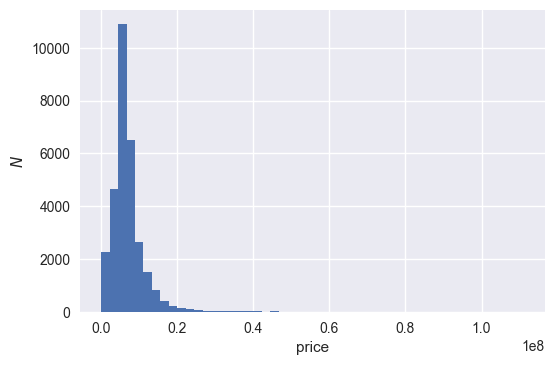

In [150]:
ax = train_df_copy['price_doc'].hist(bins=50)
ax.set_xlabel('price')
ax.set_ylabel('$N$')

The data appears to be positive-definite and may well be lognormal distributed.  In regression analyses, when some variables appear to be lognormal, [taking the log can reduce variation caused by outliers in the original distribution](https://www.analyticsvidhya.com/blog/2016/01/guide-data-exploration/#four).  The histogram is replotted after adding 1 (to avoid divergence of the logarithm function) and then taking the natural logarithm:

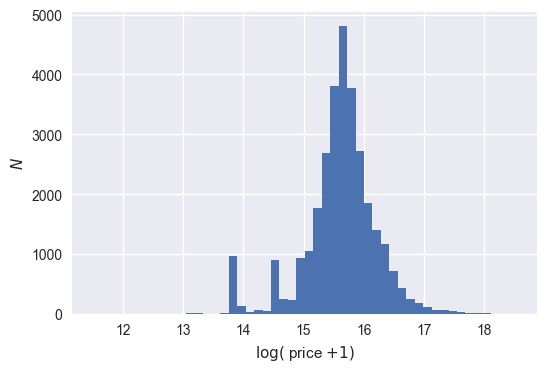

In [151]:
train_df_copy['price_doc_log'] = np.log1p(train_df_copy['price_doc'])

ax = train_df_copy['price_doc_log'].hist(bins=50)
ax.set_xlabel('$\log($ price $+1)$')
ax.set_ylabel('$N$')

The resulting histogram above seems to indicate a mostly normal distribution; there is apparent symmetry about a central value between 15 and 16.  Going forward, the transformed price variable will be used as the new target variable for the regression analysis. This should enable the model to be more robust to variation caused by extrema in the price data.

Next, explore the top-level statistics of the intrinsic properties of the real estate:

In [152]:
print "full_sq (metric): mean=%.2f," % all_df['full_sq'].mean(), "std=%.2f," % all_df['full_sq'].std(), "median=%.2f" % all_df['full_sq'].median()
print "life_sq (metric): mean=%.2f," % all_df['life_sq'].mean(), "std=%.2f," % all_df['life_sq'].std(), "median=%.2f" % all_df['life_sq'].median()
print "kitch_sq (metric): mean=%.2f," % all_df['kitch_sq'].mean(), "std=%.2f," % all_df['kitch_sq'].std(), "median=%.2f" % all_df['kitch_sq'].median()
print "num_room: mean=%.2f," % all_df['num_room'].mean(), "std=%.2f," % all_df['num_room'].std(), "median=%.2f" % all_df['num_room'].median()

full_sq (metric): mean=53.70, std=20.10, median=50.41
life_sq (metric): mean=32.66, std=22.74, median=30.40
kitch_sq (metric): mean=6.94, std=25.58, median=7.00
num_room: mean=1.88, std=0.84, median=2.00


The above variables show close connection between the mean and median values.  What is surprising is the large variation in kitchen size.  In fact, there is larger variance in this feature than in the full property size!

One might like to get a better idea of how some of these data are distributed.  One such data trend that would of interest would be price versus the year the property was built.

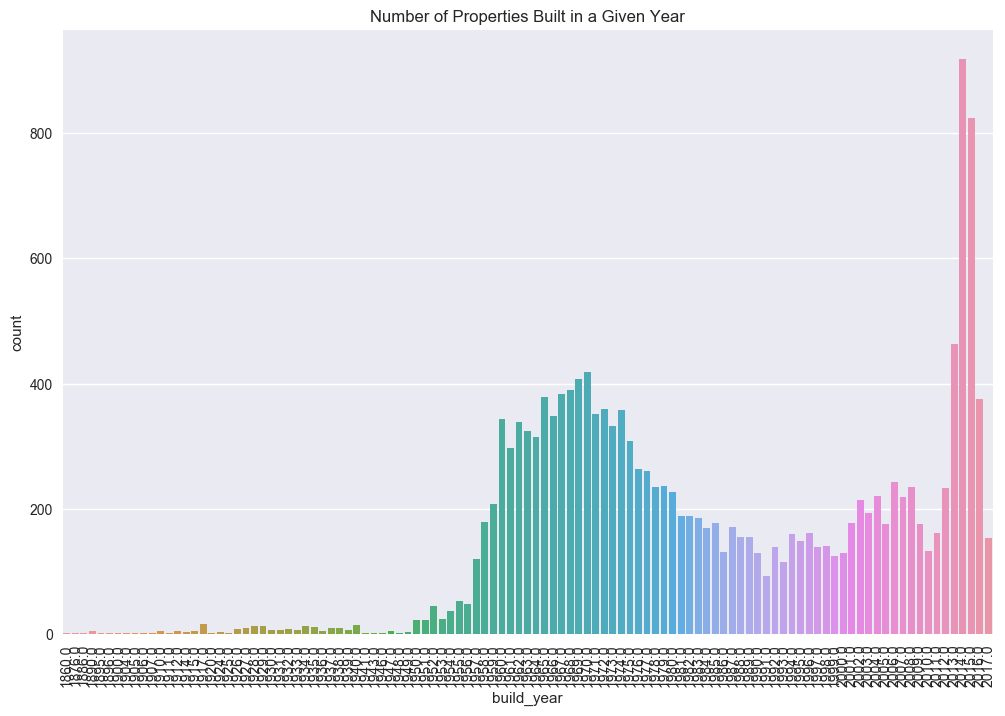

In [153]:
f, ax = plt.subplots(figsize=(12, 8))
plt.xticks(rotation='90')
# ignore properties which are too old or are yet to be built
ind = train_df_copy[(train_df['build_year'] <= 1691) | (train_df_copy['build_year'] >= 2018)].index
by_df = train_df_copy.drop(ind).sort_values(by=['build_year'])
sns.countplot(x=by_df['build_year'])
ax.set(title='Number of Properties Built in a Given Year')

From the plot above, it is clear that a majority of properties sold have been built more recently (`build_year > 2013`).  However, it is interesting to note the large amount of construction in the late 1950's and early 1960's, and the subsequent dip in housing production culminating in a minimum in 1991, near when the Soviet Union collapsed.  This is purely speculation at this point, and doesn't really hold much weight in the analysis that follows.  However, it is not inconceivable that such a trend would positively correlate with macroeconomic indicators, such as GDP.

As kind of an aside, check the mean sale price as a function of build year:

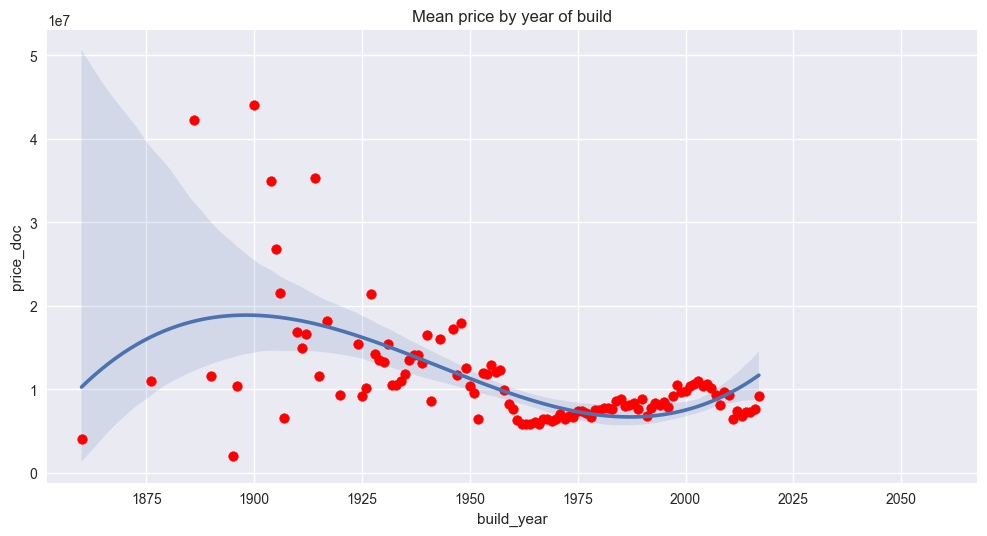

In [154]:
f, ax = plt.subplots(figsize=(12, 6))
by_price = by_df.groupby('build_year')[['build_year', 'price_doc']].mean()
# fit a third order polynomial to the data, along with error bars
sns.regplot(x="build_year", y="price_doc", data=by_price, scatter=False, order=3, truncate=True)
# plot the actual data
plt.scatter(by_price['build_year'], by_price['price_doc'], color='r')
ax.set(title='Mean price by year of build')

The above plot demonstrates a more easily predictable trend for properties built more recently (`build_year > ~1945`).  The inherent accuracy of such predictions can be seen from the tight variance bounds around the simple regression plotted alongside the raw data.  The reduction in variability could be a result of more uniformity in housing projects during the Communist years, or for some other reasons.  Again, this is merely an observation and doesn't impact the analysis that follows.

Another nice plot would be something that would show price as a function of the condition of the property.  A box-plot would work, and the `state` variable encodes the conditions of the properties:

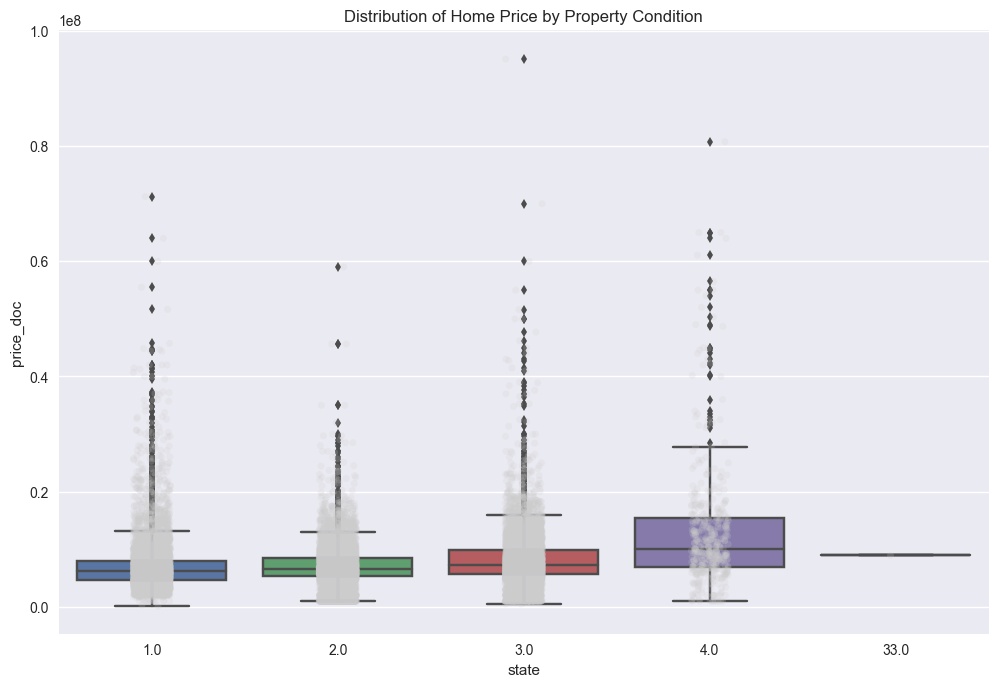

In [155]:
f, ax = plt.subplots(figsize=(12, 8))
sns.stripplot(x="state", y="price_doc", data=train_df_copy, jitter=True, alpha=.2, color=".8");
sns.boxplot(x="state", y="price_doc", data=train_df_copy)
ax.set(title='Distribution of Home Price by Property Condition', xlabel='state', 
       ylabel='price_doc')

The above plot demonstrates a few interesting points.  The first is a data quality issue; namely, what does `state = 33` mean?  After looking into the dataset itself and at forums on the Kaggle competition page, this seems to be an invalid state.  Given the frequency of occurrence and the easy-to-do data entry error of entering multiple of the same number in the same data cell, it seems the entry was made in error and the appropriate state in these instances should be `state = 3`.  The original dataset can now be updated in light of this new information and the data can be replotted.

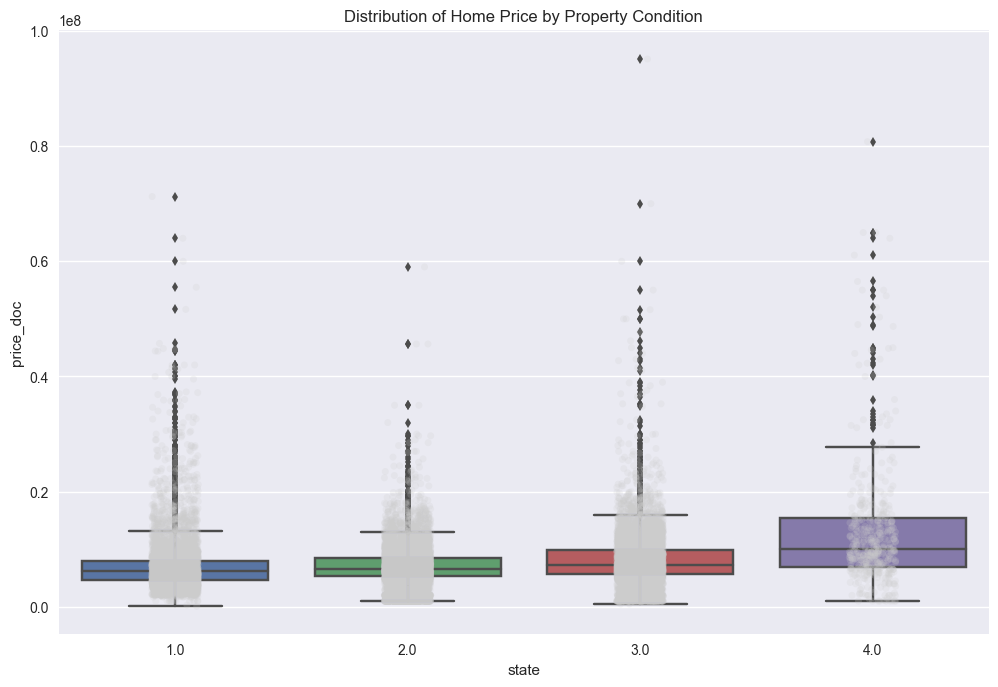

In [156]:
# state should be discrete valued between 1 and 4. There is a 33 in it that is cleary a data entry error
# replace it with 3.
all_df.loc[all_df['state'] == 33, 'state'] = 3
train_df_copy.loc[train_df_copy['state'] == 33, 'state'] = 3

# replot the box-plot with the update
f, ax = plt.subplots(figsize=(12, 8))
sns.stripplot(x="state", y="price_doc", data=train_df_copy, jitter=True, alpha=.2, color=".8");
sns.boxplot(x="state", y="price_doc", data=train_df_copy)
ax.set(title='Distribution of Home Price by Property Condition', xlabel='state', 
       ylabel='price_doc')

The trends observed above tend to make sense.  Price increases with increasing condition, or quality, of the property.  Also, properties with the lowest and highest conditions occur less frequently than those properties in just so-so condition.  Properties in the highest condition tend to have higher variability in price.  This could be as a result of high quality properties having variability in size, number of rooms, and other intrinsic properties.  There may be other trends as well; namely, extrinsic properties  (e.g. proximity to shopping, grocery stores, schools, etc...) may have an impact on price.

Before moving on with the data exploration, another irregularity is present in the dataset.  This was highlighted in the Kaggle forums for the competition and is pretty simple to fix.

In [157]:
# build_year has an erronus value 20052009.  Just pick the middle of 2005, 2009
train_df_copy.loc[train_df_copy['build_year'] == 20052009, 'build_year'] = 2007

Through inspection of the raw data, it's clear that much data is missing (indicated by `NA` in the cells).  The most frequently missing data, along with the frequency missing, is plotted below:

[<matplotlib.text.Text at 0x12c2a50d0>, <matplotlib.text.Text at 0x12c3d7810>]

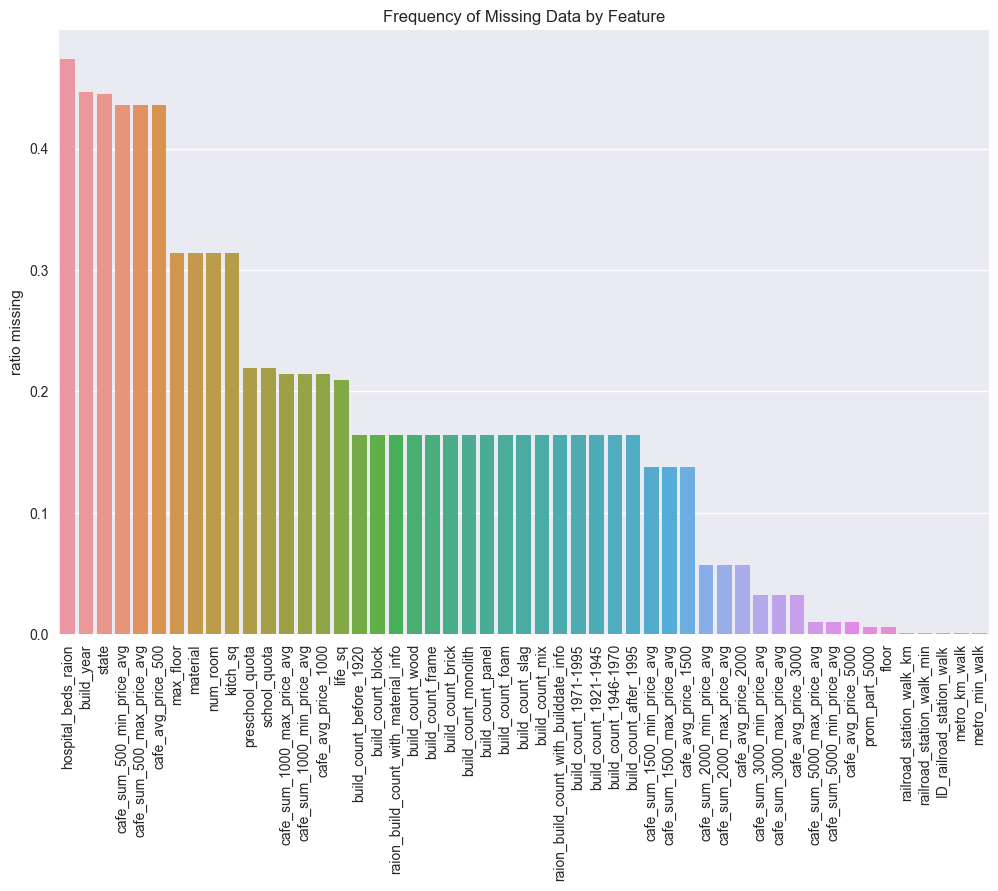

In [158]:
all_na = (all_df.isnull().sum() / len(all_df)) 
all_na = all_na.drop(all_na[all_na == 0].index).sort_values(ascending=False)

train_na = (train_df_copy.isnull().sum() / len(train_df_copy)) 
train_na = train_na.drop(train_na[train_na == 0].index).sort_values(ascending=False)

f, ax = plt.subplots(figsize=(12, 8))
plt.xticks(rotation='90')
sns.barplot(x=train_na.index, y=train_na)
ax.set(title='Frequency of Missing Data by Feature', ylabel='ratio missing')

(It should be mentioned here that "raion" indicates an area around the property, kind of like a region would be in English-speaking nations.)

For some of the data, it is not particularly surprising that values are missing.  Something like the number of hospital beds in a region may be a difficult number to come by in a real estate search.  However, it is worth noting that a number of common property features are missing with surprisingly large frequency.  Factors such as `state`, the condition of the property should definitely be recorded as part of any real estate transaction.  If it were simply missing because there is no property state (i.e. the property is a vacant lot), then this should be encoded as a separate class within the data.

### Exploratory Visualization

Before asking any more questions of the data, all of it needs to be compiled together: both the macro- and microeconomic data.  

After compilation, the first thing to consider is the importance of individual features. Arguably, the best starting point is how price relates to intrinsic features of properties.  Heatmaps show how correlated one variable is to others and are great indicators of interrelatedness within data.

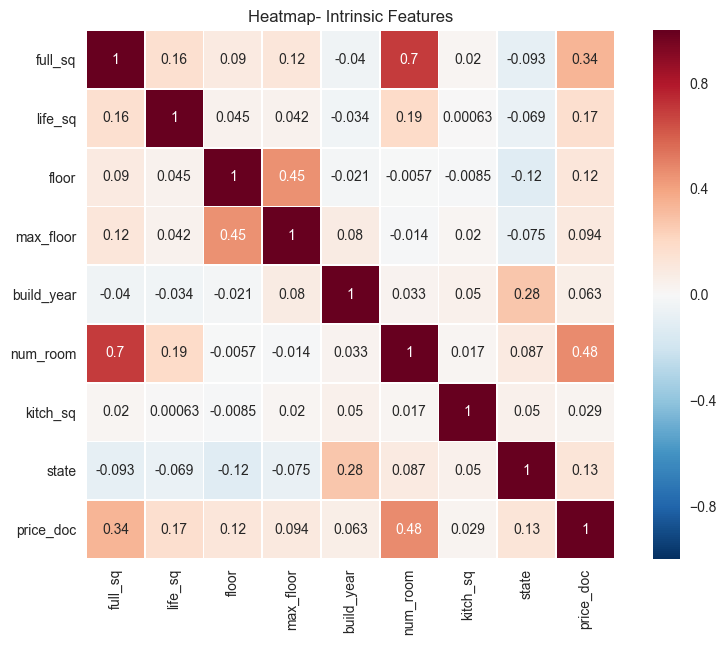

In [159]:
internal_chars = ['full_sq', 'life_sq', 'floor', 'max_floor', 'build_year', 'num_room', 'kitch_sq', 'state', 'price_doc']
corrmat = train_df_copy[internal_chars].corr()

f, ax = plt.subplots(figsize=(10, 7))
plt.xticks(rotation='90')
plt.title('Heatmap- Intrinsic Features')
sns.heatmap(corrmat, square=True, linewidths=.5, annot=True)

The heatmap above shows interrelatedness between intrinsic data of properties.

The biggest correlations to price are seen in `full_sq` and `num_room`.  This makes sense; increasing square footage and number of rooms should increase the sale price.  Also, not surprisingly, the state and floor of the property (in the case of apartments) are also positively correlated with sale price.

Before moving on, it's a good idea to get a sense of where most properties are being sold.

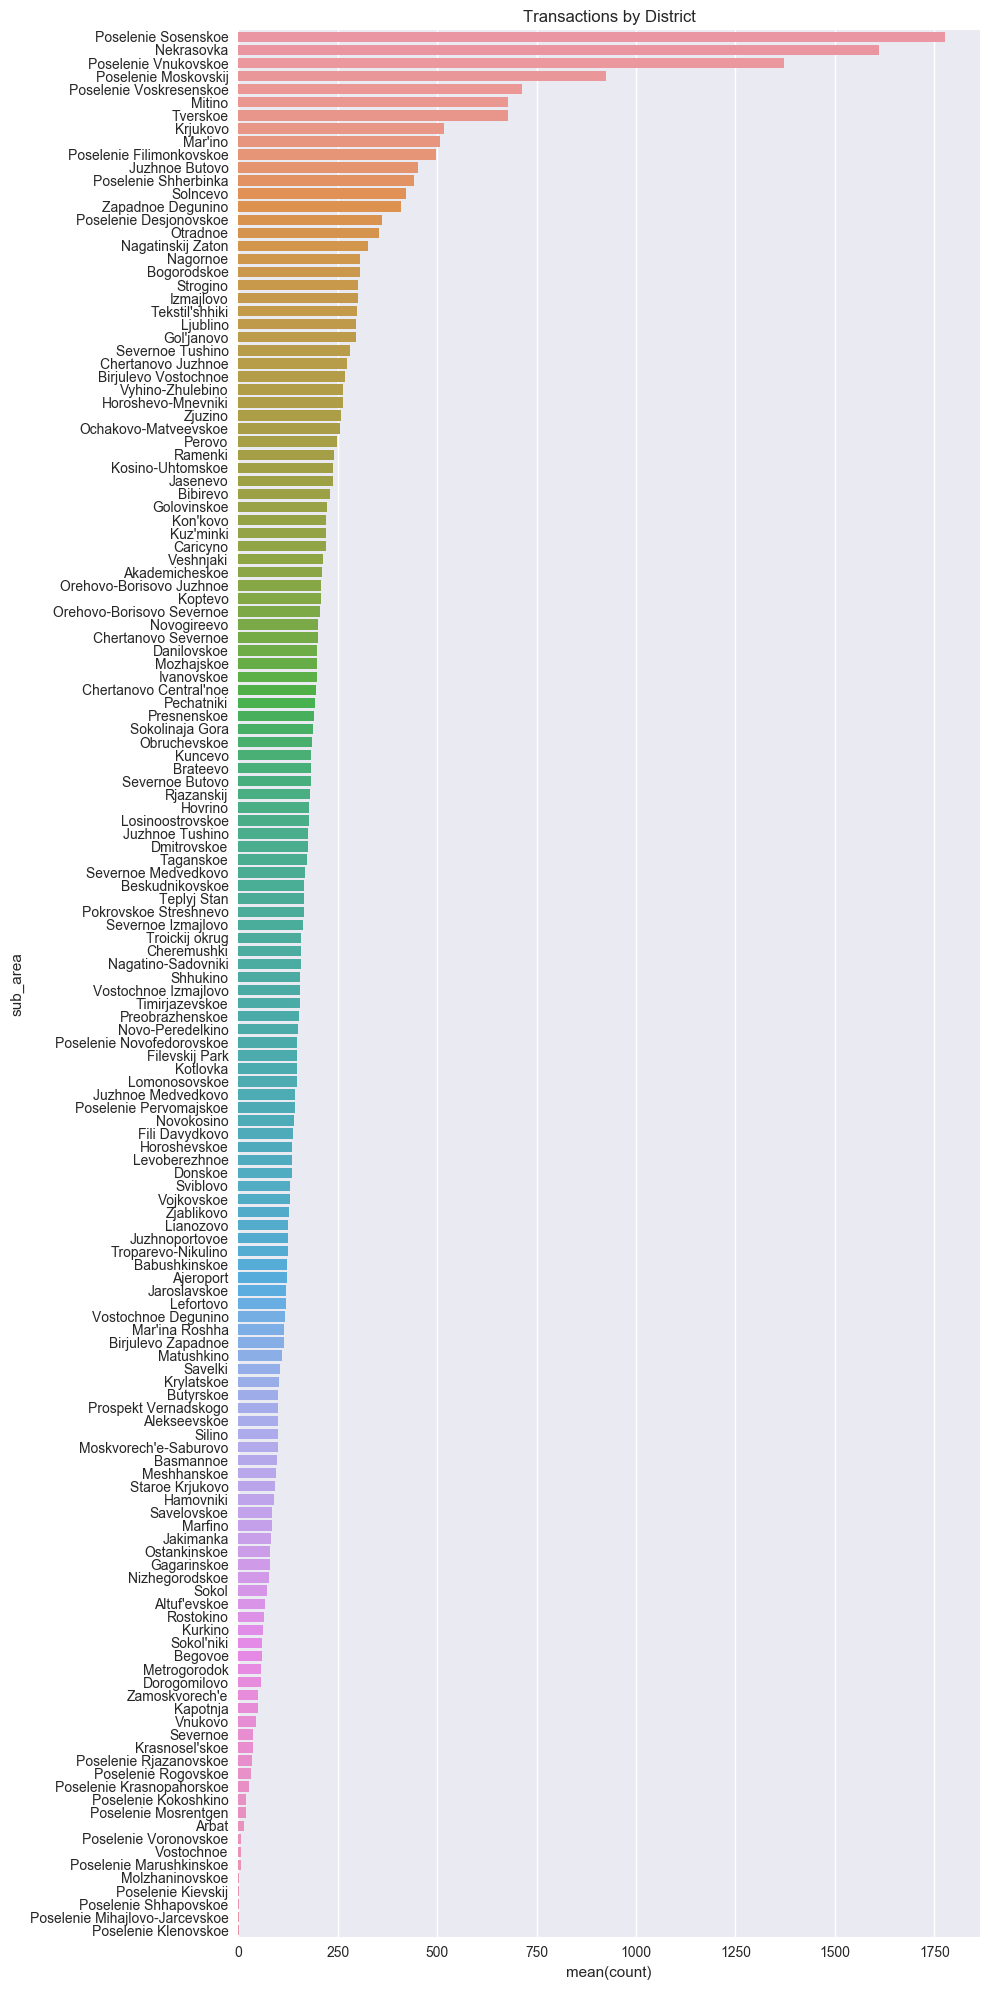

In [160]:
f, ax = plt.subplots(figsize=(10, 20))
sa_vc = train_df_copy['sub_area'].value_counts()
sa_vc = pd.DataFrame({'sub_area':sa_vc.index, 'count': sa_vc.values})
ax = sns.barplot(x="count", y="sub_area", data=sa_vc, orient="h")
ax.set(title='Transactions by District')
f.tight_layout()

The distribution of the data above shows a nearly exponential decay, so that an exponentially greater number of properties are being sold in some provinces (areas) than in others.  This is reasonable; it seems plausible that areas with higher populations would see more real estate transactions.


It's time to move on.  In the heatmap presented previously, trends between intrinsic properties were made clear.  These data showed a somewhat predictable trend: more square footage tended to mean a higher sales price.  Less clear, however, is the correlation between extrinsic properties and price.  Again, a heatmap will be illuminating here.  Look at some of the more broad features, features pertaining to local population.

In [4]:
# Deal with categorical values on train set
numeric_df = train_df_copy.select_dtypes(exclude=['object'])
obj_df = train_df_copy.select_dtypes(include=['object']).copy()

for c in obj_df:
    obj_df[c] = pd.factorize(obj_df[c])[0]

values_df_copy = pd.concat([numeric_df, obj_df], axis=1)

In [5]:
# Deal with categorical values on full set
numeric_df = all_df.select_dtypes(exclude=['object'])
obj_df = all_df.select_dtypes(include=['object']).copy()

for c in obj_df:
    obj_df[c] = pd.factorize(obj_df[c])[0]

values_df = pd.concat([numeric_df, obj_df], axis=1)

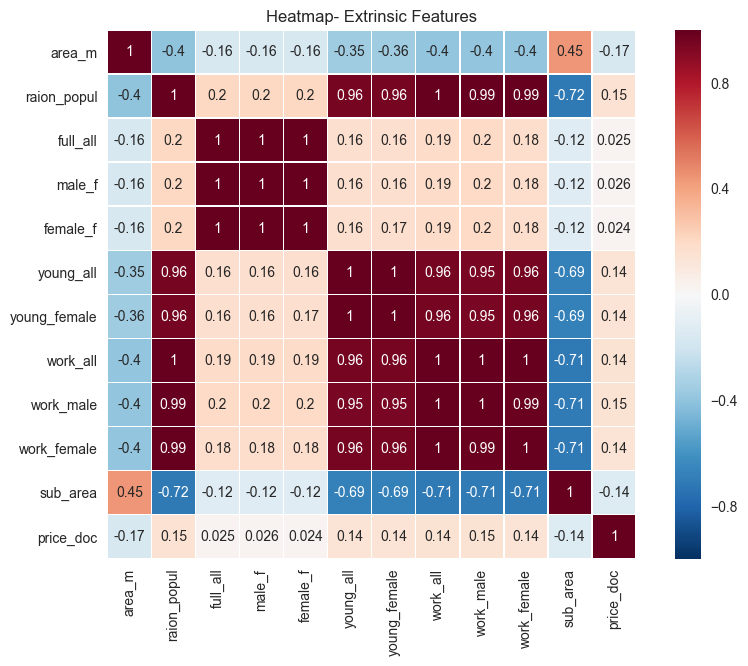

In [163]:
demo_vars = ['area_m', 'raion_popul', 'full_all', 'male_f', 'female_f', 'young_all', 'young_female', 
             'work_all', 'work_male', 'work_female', 'sub_area', 'price_doc']
corrmat = values_df_copy[demo_vars].corr()

f, ax = plt.subplots(figsize=(10, 7))
plt.xticks(rotation='90')
plt.title('Heatmap- Extrinsic Features')
sns.heatmap(corrmat, square=True, linewidths=.5, annot=True)

The variables shown above are mostly concerned with aspects of the regions themselves.  These data include region population, along with a breakdown on working age (`work_*`) and youth (`young_*`) populations.  Not surprisingly, there is moderate correlation between the region name and the area of that region.  This isn't, strictly-speaking, important to the analysis; it's just an observation.  Also, the population characteristics are highly correlated to one another; that is, the working age male population of an area (`work_male`) is highly correlated with the working age female population (`work_female`) of that same area.

There doesn't appear to be a strong correlation to any of these variables with the sales price.  Maybe other extrinsic features will show more correlation.  There are so many of these features, so maybe break them down into categories:  school, entertainment, and infrastructure.

Consider school characteristics first:

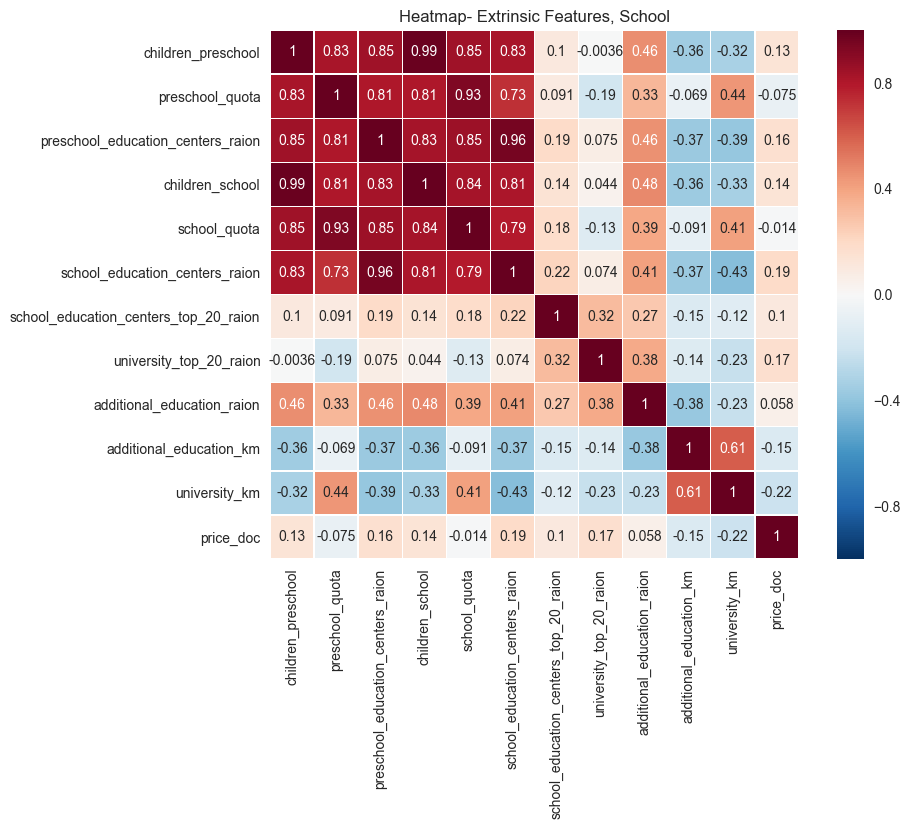

In [164]:
school_chars = ['children_preschool', 'preschool_quota', 'preschool_education_centers_raion', 'children_school', 
                'school_quota', 'school_education_centers_raion', 'school_education_centers_top_20_raion', 
                'university_top_20_raion', 'additional_education_raion', 'additional_education_km', 'university_km', 'price_doc']
corrmat = values_df_copy[school_chars].corr()

f, ax = plt.subplots(figsize=(10, 7))
plt.xticks(rotation='90')
plt.title('Heatmap- Extrinsic Features, School')
sns.heatmap(corrmat, square=True, linewidths=.5, annot=True)

The population of school-age children shows a moderate correlation with sales price, as expected. The degree of correlation is less than expected given naive assumptions about proximity to schools being a prime factor in real estate in the United States.  Of note, as well, is the negative correlation of sales prices with distance to universities.  It makes sense that, the farther one is from a university, the lower the sales price.  This trend exists in the US as well, since real estate close to universities is very desirable, and fetches a larger sales price typically.

Next, consider entertainment features:

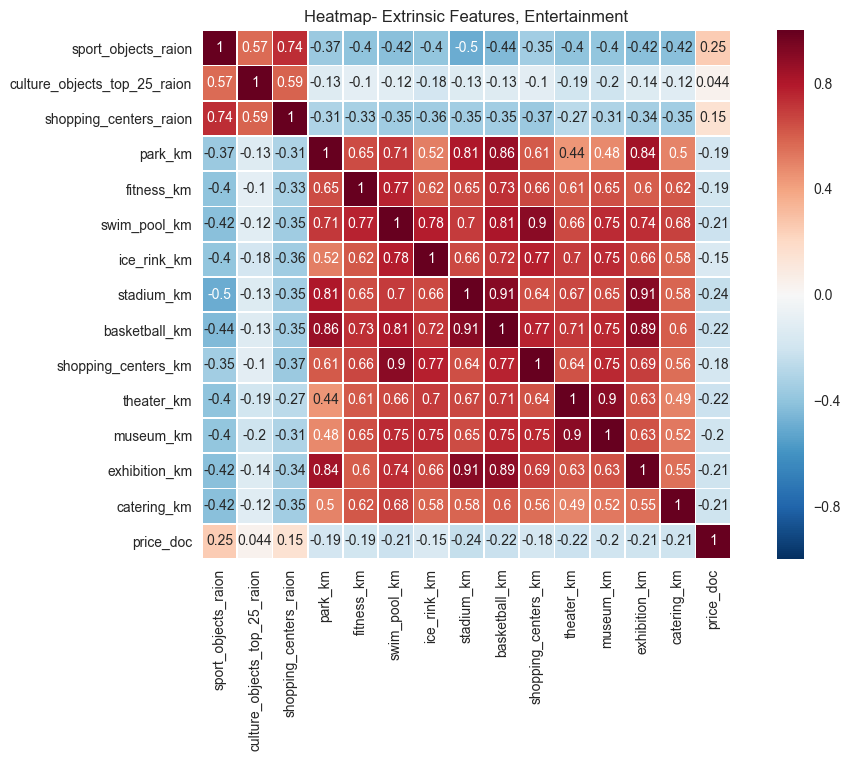

In [165]:
cult_chars = ['sport_objects_raion', 'culture_objects_top_25_raion', 'shopping_centers_raion', 'park_km', 'fitness_km', 
                'swim_pool_km', 'ice_rink_km','stadium_km', 'basketball_km', 'shopping_centers_km', 'theater_km', 'museum_km', 'exhibition_km', 'catering_km', 'price_doc']
corrmat = values_df_copy[cult_chars].corr()

f, ax = plt.subplots(figsize=(12, 7))
plt.xticks(rotation='90')
plt.title('Heatmap- Extrinsic Features, Entertainment')
sns.heatmap(corrmat, square=True, linewidths=.5, annot=True)

The data above again makes sense in the aggregate: the farther a property is from recreational attractions, like shopping centers or museums, the lower the sales price.  Put another way, real estate near cultural and recreational attractions is more desirable and is typically more valuable.

Finally, infrastructure features are considered:

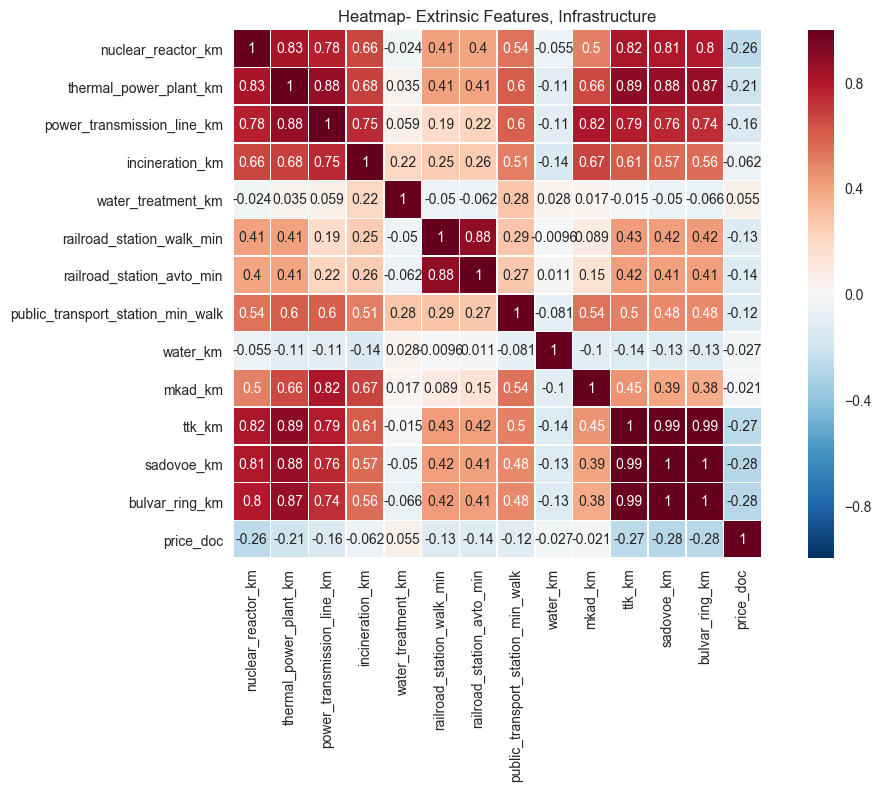

In [166]:
inf_features = ['nuclear_reactor_km', 'thermal_power_plant_km', 'power_transmission_line_km', 'incineration_km',
                'water_treatment_km', 'railroad_station_walk_min', 
                'railroad_station_avto_min', 
                'public_transport_station_min_walk', 'water_km', 'mkad_km', 'ttk_km', 'sadovoe_km','bulvar_ring_km', 'price_doc']
corrmat = values_df_copy[inf_features].corr()

f, ax = plt.subplots(figsize=(12, 7))
plt.xticks(rotation='90')
plt.title('Heatmap- Extrinsic Features, Infrastructure')
sns.heatmap(corrmat, square=True, linewidths=.5, annot=True)

The data above is surprising.  Naively, one would assume that being closer to power generation stations would be undesirable and would show positive correlation with price.  However, the data indicates otherwise.  Other data, like correlation of price with distance to public transportation, makes sense in the context provided.

Next, consider correlation between price and macroeconomic indicators:

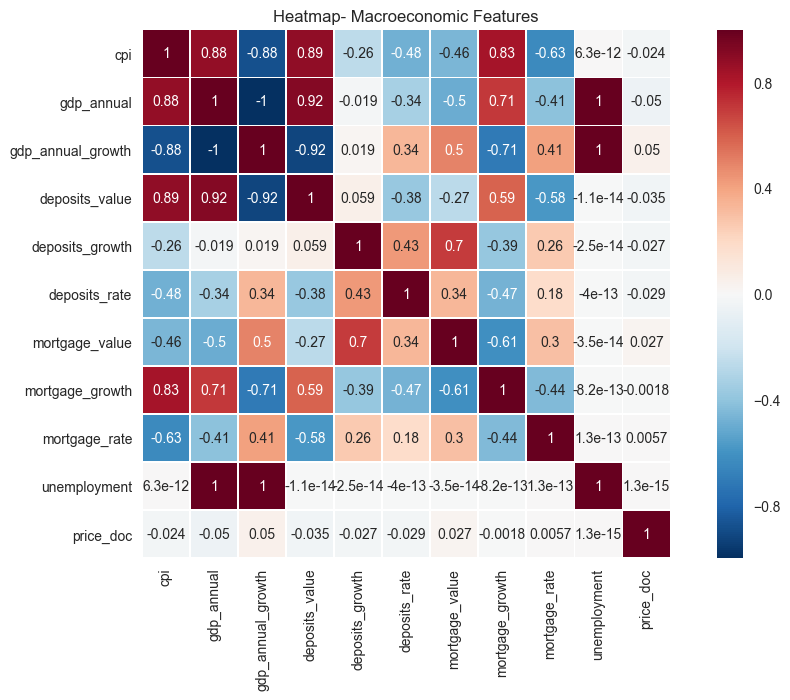

In [167]:
values_df['price_doc'] = train_df_copy['price_doc']
macro_features = ['cpi', 'gdp_annual', 'gdp_annual_growth', 
                  'deposits_value', 'deposits_growth', 'deposits_rate',
                  'mortgage_value', 'mortgage_growth', 'mortgage_rate',
                  'unemployment',
                  'price_doc']
corrmat = values_df[macro_features].corr()

f, ax = plt.subplots(figsize=(12, 7))
plt.xticks(rotation='90')
plt.title('Heatmap- Macroeconomic Features')
sns.heatmap(corrmat, square=True, linewidths=.5, annot=True)

This data is pretty interesting.  As expected, intrinsic and extrinsic properties of the real estate are much more correlated to sales price than broader macroeconomic features.  This is exactly as one would expect.  It is surprising, though, that mortgage properties aren't more positively corelated with price.  It would seem that lower mortgage rates might entice more buyers, and with more buyers, one might expect higher prices.  However, the data shows almost no correlation to price.  It is also interesting that prices aren't more negatively correlated with unempoyment.  Again, naively, it would seem that higher unemplyment would mean lower prices on real estate transactions.

### Algorithms and Techniques

As mentioned previously, `XGBoost`, along with the `sklearn` wrapper `XGBRegressor`, will be used for performing the regression analysis.  This package was chosen because of its success in machine learning competitions of various scales.  The use of boosted trees will allow for a model that requires minimal feature engineering (see [this](https://www.kaggle.com/c/allstate-claims-severity/discussion/24500)); all that needs to be done is hyperparameter tuning.  The package `sklearn` has two very nice optimization frameworks for estimator tuning: `RandomizedSearchCV` and `GridSearchCV`.  `RandomizedSearchCV` allows for sampling the parameter space by random draws from probability distributions.  The choice of distribution depends upon the parameter being tuned, however the uniform distribution is a great choice; this is because it allows for sampling of a spatial structure where each point has equal probability.  The equal probability is desirable since, a priori, there are minimal assumptions made about model performance as a function of the hyperparameters.

As with all regression techniques, a model is developed here which minimizes error of a predicted target variable versus a known target variable from a training set comprised of feature vectors.  How well the model performs is a function of several things; chief among them being choice of hyperparameters and structure of the input feature data.  Both of these things will be discussed subsequently in the Methodology section.

### Benchmark

No real established regression benchmark exists for this dataset.  However, a simple process can be used to create a benchmark that can be built on through hyperparameter tuning.  [Random forest regressors](http://www-bcf.usc.edu/~gareth/ISL) provide a simple out-of-the box regressor that can be improved upon with more advanced regression techniques (e.g. XGBoost).  Random forests provide comparable performance to boosting methods (see [this](http://fastml.com/what-is-better-gradient-boosted-trees-or-random-forest/)) without having to perform much tuning to optimize.  The `sklearn.ensemble` package has [RandomForestRegressor](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html).  The performance using this regressor is:

In [6]:
# load packages
from sklearn.preprocessing import Imputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [7]:
# reload the data (a lot of processing happened above, clean it up a bit)
df_train = pd.read_csv("./data/train.csv", parse_dates=['timestamp'])
df_test = pd.read_csv("./data/test.csv", parse_dates=['timestamp'])
df_macro = pd.read_csv("./data/macro.csv", parse_dates=['timestamp'])

# ylog will be log(1+y), as suggested by https://github.com/dmlc/xgboost/issues/446#issuecomment-135555130
ylog_train_all = np.log1p(df_train['price_doc'].values)
id_test = df_test['id']

df_train.drop(['id', 'price_doc'], axis=1, inplace=True)
df_test.drop(['id'], axis=1, inplace=True)

# Build df_all = (df_train+df_test).join(df_macro)
num_train = len(df_train)
df_all = pd.concat([df_train, df_test])
df_all = pd.merge_ordered(df_all, df_macro, on='timestamp', how='left')

# Remove timestamp column (may overfit the model in train)
df_all.drop(['timestamp'], axis=1, inplace=True)

# Deal with categorical values
df_numeric = df_all.select_dtypes(exclude=['object'])
df_obj = df_all.select_dtypes(include=['object']).copy()

for c in df_obj:
    df_obj[c] = pd.factorize(df_obj[c])[0]

df_values = pd.concat([df_numeric, df_obj], axis=1)

X_all = df_values.values

# do feature scaling (try it out at least) comment out the next two lines if not needed/wanted
# Fit a per-column scaler
X_scaler = Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0).fit(X_all)
# Apply the scaler to X
scaled_X = X_scaler.transform(X_all)

# uncomment to avoid feature scaling
#scaled_X = X_all

# Create a validation set, with 30% of data
num_train = len(df_train)
X_train_all = scaled_X[:num_train]
X_train, X_val, ylog_train, ylog_val = train_test_split(X_train_all, ylog_train_all, test_size=0.3, random_state=42) 

X_test = scaled_X[num_train:]

df_columns = df_values.columns[:len(X_train[0])]

print 'X shape is', scaled_X.shape 
print 'X_train shape is', X_train.shape 
print 'y_train shape is', ylog_train.shape
print 'X_val shape is', X_val.shape
print 'y_val shape is', ylog_val.shape
print 'X_test shape is', X_test.shape

X shape is (38133, 388)
X_train shape is (21329, 388)
y_train shape is (21329,)
X_val shape is (9142, 388)
y_val shape is (9142,)
X_test shape is (7662, 388)


In [181]:
estimator = RandomForestRegressor(random_state=0, n_estimators=100, verbose=1)
estimator.fit(X_train, ylog_train)
print "Score on the validation set (~0.30 of training set) = %.2f" % estimator.score(X_val, ylog_val)

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  6.3min finished


Score on the validation set (~0.30 of training set) = 0.39


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.4s finished


Part of this project is to see how well different models perform with respect to [Kaggle's leaderboard score](https://www.kaggle.com/c/sberbank-russian-housing-market/leaderboard).  To create the submission csv file to be scored, execute the following:

In [184]:
# predict the log(1+p)
ylog_pred = estimator.predict(X_test)
# convert to price
y_pred = np.exp(ylog_pred) - 1

# create pandas dataframe
df_sub = pd.DataFrame({'id': id_test, 'price_doc': y_pred})
# write csv file
df_sub.to_csv('sub_rfr.csv', index=False)

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished


The public leaderboard score for this submission was 0.41168, which is significantly worse than the current best score of 0.30728.  But, as a first shot with no tuning, this isn't terrible.

Another preliminary plot can be made now that this estimator has been created:  feature importance can be estimated using the attribute `estimator.feature_importances_`.

Feature ranking:
1. full_sq (0.247312)
2. life_sq (0.029145)
3. floor (0.021956)
4. max_floor (0.019321)
5. material (0.016129)
6. build_year (0.010245)
7. num_room (0.008503)
8. kitch_sq (0.008431)
9. state (0.007571)
10. area_m (0.007555)
11. raion_popul (0.007461)
12. green_zone_part (0.007405)
13. indust_part (0.007018)
14. children_preschool (0.006694)
15. preschool_quota (0.006586)
16. preschool_education_centers_raion (0.006480)
17. children_school (0.006230)
18. school_quota (0.006210)
19. school_education_centers_raion (0.006152)
20. school_education_centers_top_20_raion (0.006061)
21. hospital_beds_raion (0.005978)
22. healthcare_centers_raion (0.005859)
23. university_top_20_raion (0.005772)
24. sport_objects_raion (0.005581)
25. additional_education_raion (0.005534)


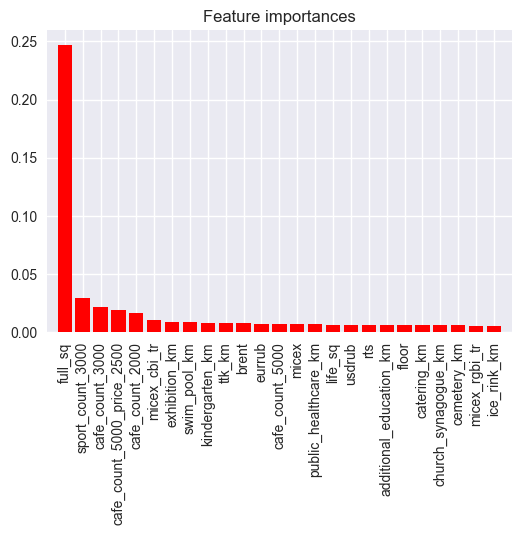

In [191]:
importances = estimator.feature_importances_
sd = np.std([estimator.feature_importances_ for tree in estimator.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# only take the top 25 so the plot isn't a mess
ind = indices[:25]

# Print the feature ranking
print("Feature ranking:")

for f in range(len(ind)):
    print("%d. %s (%f)" % (f + 1, df_columns[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(len(ind)), importances[ind],
       color="r", yerr=sd[ind], align="center")
plt.xticks(range(len(ind)), df_columns[ind])
plt.xticks(rotation='90')
plt.xlim([-1, len(ind)])
plt.show()

This makes sense, since one would expect that the most important features, with regard to sales price, would be the size of the property and recreational/entertainment features nearby (cafes, sports, etc...).

## III. Methodology

As a starting point, [this](https://www.kaggle.com/bguberfain/naive-xgb-lb-0-317) was used as a reference.

### Data Preprocessing and Algorithm Implementation

There are a few different features that are not modeled as of yet, but could be important.  Such features include the month, day-of-week, and the year of the transaction:

In [8]:
df_all = pd.concat([df_train, df_test])
df_all = pd.merge_ordered(df_all, df_macro, on='timestamp', how='left')

# Add month, day-of-week, and year
df_all['month'] = df_all.timestamp.dt.month
df_all['dow'] = df_all.timestamp.dt.dayofweek
df_all['year'] = df_all.timestamp.dt.year

# Remove timestamp column (may overfit the model in train)
df_all.drop(['timestamp'], axis=1, inplace=True)

It would seem reasonable that some months would be better for purchasing property than others; real estate may be less desirable in winte months, for example.  Also, the year of the transaction may be significant if there are significant economic or social trends that were important that year (e.g. the fall of the Soviet Union in the early-1990's).

The ratio of room space to total space may also be interesting.  For instance, someone might not want a tiny kitchen in an otherwise large home.  Also, apartments on the higher floors will most likely fetch higher prices than those on lower floors.  Therefore, one should look at the ratio of the floor to the maximum number of floors in an apartment building.  A small "fudge-factor" is added to the division in the `rel_floor` value computation to avoid divide-by-zero issues.

In [9]:
# Other feature engineering
df_all['rel_floor'] = (df_all['floor'] / (df_all['max_floor']+1.e-6).astype(np.float32)
df_all['rel_kitch_sq'] = df_all['kitch_sq'] / df_all['full_sq'].astype(np.float32)
df_all['rel_life_sq'] = df_all['life_sq'] / df_all['full_sq'].astype(np.float32)

Now, address with the categorical values again in the new derived dataset.  Also, deal with `NaN`'s and scale the data.

In [10]:
# Deal with categorical values
df_numeric = df_all.select_dtypes(exclude=['object'])
df_obj = df_all.select_dtypes(include=['object']).copy()

for c in df_obj:
    df_obj[c] = pd.factorize(df_obj[c])[0]

df_values = pd.concat([df_numeric, df_obj], axis=1)

# Convert to numpy values
X_all = df_values.values

# do feature scaling (try it out at least) comment out the next two lines if not needed/wanted
# Fit a per-column scaler
X_scaler = Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0).fit(X_all)
# Apply the scaler to X
scaled_X = X_scaler.transform(X_all)

It should be clear from the heatmaps that the data is very [collinear](https://www.kaggle.com/robertoruiz/dealing-with-multicollinearity).  This would seem to indicate that there might be a gain in model performance if the feature set was reduced to a combination of linearly independent pseudofeatures.  This could be accomplished via [principal components analysis](http://setosa.io/ev/principal-component-analysis/).  First, a baseline needs to be established to see if PCA might help.

In [238]:
from sklearn.decomposition import PCA
import xgboost as xgb

/Users/jdinius/miniconda2/envs/ml_capstone/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [11]:
X_train_all = scaled_X[:num_train]
X_train, X_val, ylog_train, ylog_val = train_test_split(X_train_all, ylog_train_all, test_size=0.3, random_state=42) 

X_test = scaled_X[num_train:]

In [253]:
estimator = xgb.XGBRegressor(seed=0, n_estimators=100, silent=False)
estimator.fit(X_train, ylog_train)
score = estimator.score(X_val, ylog_val)
print "Score on the validation set (~0.30 of training set) = %.7f" % score

Score on the validation set (~0.30 of training set) = 0.4097120


Create a submission for this simple effort with no PCA.

In [254]:
# predict the log(1+p)
ylog_pred = estimator.predict(X_test)
# convert to price
y_pred = np.exp(ylog_pred) - 1

# create pandas dataframe
df_sub = pd.DataFrame({'id': id_test, 'price_doc': y_pred})
# write csv file
df_sub.to_csv('sub_xgb_base.csv', index=False)

The public leaderboard score is 0.39276, which is a little better than the random forests' score.  But, maybe performance might be better with PCA.  First, define a helper function to aid in the analysis.

In [251]:
def pipeline(X_input=scaled_X, ylog_input=ylog_train_all, n_comp=100, n_train=num_train, whiten=False):
    pca = PCA(n_components=n_comp,whiten=whiten)
    X_pca = pca.fit_transform(X_input)
    X_train_all = X_pca[:num_train]
    X_train, X_val, ylog_train, ylog_val = train_test_split(X_train_all, ylog_input, test_size=0.3, random_state=42) 
    
    estimator = xgb.XGBRegressor(seed=0, n_estimators=100, silent=False)
    estimator.fit(X_train, ylog_train)
    score = estimator.score(X_val, ylog_val)
    print "Score on the validation set (~0.30 of training set) = %.7f" % score
    return score

This function will take in data to split into training and validation sets.  To ensure proper comparison, common seeds for both the split and regressors will be used.  This will ensure that algorithm performance improvements will truly be due to choice of principal components and not due to random variation.  The R2 score is used as determinator.  Now, create a simple routine to select and evaluate sensitivity of XGBoost to principal component selection.

In [249]:
from scipy.stats import randint as sp_randint
low = 10 # floor on pc's allowed
high = len(scaled_X[0])
n_trials = 10
old_score = -1.
rvs = sp_randint.rvs(low, high, size=n_trials, random_state=0)
for rnd in rvs:
    print rnd, " components..."
    score = pipeline(n_comp=rnd)
    if score > old_score:
        old_score = score
        n_pca = rnd

182  components...
Score on the validation set (~0.30 of training set) = 0.3745939
57  components...
Score on the validation set (~0.30 of training set) = 0.3128528
127  components...
Score on the validation set (~0.30 of training set) = 0.3759044
202  components...
Score on the validation set (~0.30 of training set) = 0.3754324
333  components...
Score on the validation set (~0.30 of training set) = 0.3754956
261  components...
Score on the validation set (~0.30 of training set) = 0.3751191
205  components...
Score on the validation set (~0.30 of training set) = 0.3734659
369  components...
Score on the validation set (~0.30 of training set) = 0.3778734
19  components...
Score on the validation set (~0.30 of training set) = 0.1566555
221  components...
Score on the validation set (~0.30 of training set) = 0.3742768


This didn't improve model performance.  In fact, performance was degraded.  It's also clear that there seems to be nearly indistinguishable scores once the number of principal components exceeds some threshold (about 127 in this case).  There is another PCA option that can be utilized to try that might improve performance:  whitening.  Whitening the data is a way to further remove correlation from feature vectors resulting from a principal components transformation.

In [252]:
old_score = -1.
rvs = sp_randint.rvs(low, high, size=n_trials, random_state=0)
for rnd in rvs:
    print rnd, " components..."
    score = pipeline(n_comp=rnd, whiten=True)
    if score > old_score:
        old_score = score
        n_pca = rnd

182  components...
Score on the validation set (~0.30 of training set) = 0.3737520
57  components...
Score on the validation set (~0.30 of training set) = 0.3119953
127  components...
Score on the validation set (~0.30 of training set) = 0.3754829
202  components...
Score on the validation set (~0.30 of training set) = 0.3745342
333  components...
Score on the validation set (~0.30 of training set) = 0.3754956
261  components...
Score on the validation set (~0.30 of training set) = 0.3741389
205  components...
Score on the validation set (~0.30 of training set) = 0.3745446
369  components...
Score on the validation set (~0.30 of training set) = 0.3778734
19  components...
Score on the validation set (~0.30 of training set) = 0.1577009
221  components...
Score on the validation set (~0.30 of training set) = 0.3744232


These results are indistinguishable from the non-whitening results.  Therefore it is concluded that it is not worth using principal components; stick with the dataset as-is and focus on tuning the hyperparameters for XGBoost.

### Refinement

Following [this procedure](https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/), the tuning process is as follows:

| Step #: | Process                                 |
|---------|-----------------------------------------|
| Step 1: | Tune `max_depth` and `min_child_weight` |
| Step 2: | Tune `gamma`                            |
| Step 3: | Tune `subsample` and `colsample_bytree` |
| Step 4: | Tune regularization parameters          |
| Step 5: | Tune `learning_rate`                    |
| Step 6: | Tune `n_estimators`                     |

The functions `RandomizedSearchCV` and `GridSearchCV` functions from `sklearn.model_selection` are used for the optimization.  The resource referenced also provides the range of values to use for the tuning.  See [this](http://xgboost.readthedocs.io/en/latest/parameter.html) for more details on hyperparameter descriptions.

In [262]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from time import time

Define a helper function to report the top scores from the tuning steps.

In [258]:
# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.5f} (std: {1:.5f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

    return

#### Step 1: Tune `max_depth` and `min_child_weight`

The parameters `max_depth` and `min_child_weight` are the number of layers of decision trees used and the minimum sum of instance weight in a tree's child, respectively.

In [264]:
fixed_params_rd1 = {
    'n_estimators': 500
}

# specify parameters and distributions to sample from
cv_params_rd1 = {"max_depth": sp_randint(3,11),
                 "min_child_weight": sp_randint(1,6)}

# randomized search
n_iter_search = 25
optimized_XGB = RandomizedSearchCV(xgb.XGBRegressor(**fixed_params_rd1),
                               cv_params_rd1,
                               scoring = 'neg_mean_squared_error',
                               cv = 5,
                               n_iter = n_iter_search,
                               n_jobs = 4,
                               verbose = 1)


start = time()

optimized_XGB.fit(X_train, ylog_train)

print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(optimized_XGB.cv_results_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed: 38.8min
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed: 106.2min finished


RandomizedSearchCV took 6455.26 seconds for 25 candidates parameter settings.
Model with rank: 1
Mean validation score: -0.21743 (std: 0.00763)
Parameters: {'max_depth': 3, 'min_child_weight': 5}

Model with rank: 2
Mean validation score: -0.21993 (std: 0.00843)
Parameters: {'max_depth': 4, 'min_child_weight': 2}

Model with rank: 3
Mean validation score: -0.22030 (std: 0.00792)
Parameters: {'max_depth': 4, 'min_child_weight': 3}



It is a little unclear what the optimal value for `min_child_weight` is, since the value reported for the optimal estimator is at the ceiling of the values tested.  Therefore, test values greater than this and see if performance improves.

In [266]:
estimator = xgb.XGBRegressor(seed=0, n_estimators=500, max_depth=3, min_child_weight=5, silent=False)
estimator.fit(X_train, ylog_train)
score = estimator.score(X_val, ylog_val)
print "Score on the validation set (~0.30 of training set) = %.5f" % score

Score on the validation set (~0.30 of training set) = 0.41664


In [268]:
estimator = xgb.XGBRegressor(seed=0, n_estimators=500, max_depth=3, min_child_weight=6, silent=False)
estimator.fit(X_train, ylog_train)
score = estimator.score(X_val, ylog_val)
print "Score on the validation set (~0.30 of training set) = %.5f" % score

Score on the validation set (~0.30 of training set) = 0.41860


In [267]:
estimator = xgb.XGBRegressor(seed=0, n_estimators=500, max_depth=3, min_child_weight=7, silent=False)
estimator.fit(X_train, ylog_train)
score = estimator.score(X_val, ylog_val)
print "Score on the validation set (~0.30 of training set) = %.5f" % score

Score on the validation set (~0.30 of training set) = 0.41821


Performance improved a bit with `min_child_weight` increased to 6, so this value will be used going forward.  The csv for Kaggle performance is now created below:

In [269]:
# predict the log(1+p)
ylog_pred = estimator.predict(X_test)
# convert to price
y_pred = np.exp(ylog_pred) - 1

# create pandas dataframe
df_sub = pd.DataFrame({'id': id_test, 'price_doc': y_pred})
# write csv file
df_sub.to_csv('sub_xgb_rd1.csv', index=False)

The public score is 0.34795, which is a significant improvement over the previous score of 0.39276.

#### Step 2:  Tune `gamma`

The hyperparameter `gamma` is the minimum loss reduction required to create a further partition.  This can also be thought of as information gain required from a certain split in order to make that split.

In [270]:
from scipy.stats import uniform as sp_uniform

In [272]:
fixed_params_rd2 = {
    'n_estimators': 500,
    "max_depth": 3,
    "min_child_weight": 6
}

# specify parameters and distributions to sample from
rvs = sp_uniform(0.,0.3)
cv_params_rd2 = {"gamma": rvs}

# randomized search
n_iter_search = 15
optimized_XGB = RandomizedSearchCV(xgb.XGBRegressor(**fixed_params_rd2),
                               cv_params_rd2,
                               scoring = 'neg_mean_squared_error',
                               cv = 5,
                               n_iter = n_iter_search,
                               n_jobs = 4,
                               verbose = 1)


start = time()

optimized_XGB.fit(X_train, ylog_train)

print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed: 15.8min
[Parallel(n_jobs=4)]: Done  75 out of  75 | elapsed: 27.2min finished


RandomizedSearchCV took 1713.08 seconds for 15 candidates parameter settings.


In [278]:
report(optimized_XGB.cv_results_)

# predict the log(1+p)
ylog_pred = optimized_XGB.best_estimator_.predict(X_test)
# convert to price
y_pred = np.exp(ylog_pred) - 1

# create pandas dataframe
df_sub = pd.DataFrame({'id': id_test, 'price_doc': y_pred})
# write csv file
df_sub.to_csv('sub_xgb_rd2.csv', index=False)

score = optimized_XGB.best_estimator_.score(X_val, ylog_val)
print "Score on the validation set (~0.30 of training set) = %.5f" % score

Model with rank: 1
Mean validation score: -0.21635 (std: 0.00712)
Parameters: {'gamma': 0.12181820933103936}

Model with rank: 2
Mean validation score: -0.21650 (std: 0.00729)
Parameters: {'gamma': 0.20868217554374732}

Model with rank: 3
Mean validation score: -0.21650 (std: 0.00700)
Parameters: {'gamma': 0.1456312910685548}

Score on the validation set (~0.30 of training set) = 0.41756


The public score for this step is 0.34814.  Both the public and R2 scores are not significantly different than those from the previous step.  Both are still an improvement over the random forest baseline.

#### Step 3:  Tune `subsample` and `colsample_bytree`

The hyperparameters `subsample` and `colsample_bytree` are the subsample ratio of training data and the subsample ratio of columns when constructing a new tree, respectively.  The first parameter is to prevent overfitting to the training data.

In [279]:
fixed_params_rd3 = {
    'n_estimators': 500,
    "max_depth": 3,
    "min_child_weight": 6, 
    'gamma': 0.122
}

# specify parameters and distributions to sample from
rvs_1 = sp_uniform(0.6,0.4)
rvs_2 = sp_uniform(0.6,0.4)
cv_params_rd3 = {"subsample": rvs_1,
                 "colsample_bytree": rvs_2}

# randomized search
n_iter_search = 50
optimized_XGB = RandomizedSearchCV(xgb.XGBRegressor(**fixed_params_rd3),
                               cv_params_rd3,
                               scoring = 'neg_mean_squared_error',
                               cv = 5,
                               n_iter = n_iter_search,
                               n_jobs = 4,
                               verbose = 1)


start = time()

optimized_XGB.fit(X_train, ylog_train)

print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(optimized_XGB.cv_results_)

# predict the log(1+p)
ylog_pred = optimized_XGB.best_estimator_.predict(X_test)
# convert to price
y_pred = np.exp(ylog_pred) - 1

# create pandas dataframe
df_sub = pd.DataFrame({'id': id_test, 'price_doc': y_pred})
# write csv file
df_sub.to_csv('sub_xgb_rd3.csv', index=False)

score = optimized_XGB.best_estimator_.score(X_val, ylog_val)
print "Score on the validation set (~0.30 of training set) = %.5f" % score

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed: 14.9min
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 61.8min
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed: 81.2min finished


RandomizedSearchCV took 4929.91 seconds for 50 candidates parameter settings.
Model with rank: 1
Mean validation score: -0.21567 (std: 0.00755)
Parameters: {'subsample': 0.91681240477025272, 'colsample_bytree': 0.63109952938936653}

Model with rank: 2
Mean validation score: -0.21580 (std: 0.00721)
Parameters: {'subsample': 0.97493920653568367, 'colsample_bytree': 0.86146309470589277}

Model with rank: 3
Mean validation score: -0.21602 (std: 0.00741)
Parameters: {'subsample': 0.97527816500403364, 'colsample_bytree': 0.73918613980754966}

Score on the validation set (~0.30 of training set) = 0.41667


The public score for this step is 0.34924.  Both the public and R2 scores are not significantly different than those from the previous step.  Both are still an improvement over the random forest baseline.

#### Step 4: Tune regularization parameters

The hyperparameters `reg_alpha` and `reg_lambda` are the [L1 and L2 regularization terms](http://cs.nyu.edu/~rostami/presentations/L1_vs_L2.pdf), respectively.  The function `GridSearchCV` is used due to the scale desired on the L1 term `reg_alpha`.  It would be difficult to randomly sample and hit the desired scales to test for this hyperparameter.

In [281]:
fixed_params_rd4 = {
    'n_estimators': 500,
    'subsample': 0.917,
    'colsample_bytree': 0.631,
    "max_depth": 3,
    "min_child_weight": 6,
    'gamma': 0.122
}

# specify parameters to search across
cv_params_rd4 = {'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05],
                 'reg_lambda': [0.6, 0.7, 0.8, 0.9, 1.]}

# grid search
optimized_XGB = GridSearchCV(xgb.XGBRegressor(**fixed_params_rd4),
                         cv_params_rd4,
                         scoring = 'neg_mean_squared_error',
                         cv = 5,
                         n_jobs = 4,
                         verbose = 1)


start = time()

optimized_XGB.fit(X_train, ylog_train)

print("GridSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), 25)) #25 = number of reg_alpha * number of reg_lambda entries

report(optimized_XGB.cv_results_)

# predict the log(1+p)
ylog_pred = optimized_XGB.best_estimator_.predict(X_test)
# convert to price
y_pred = np.exp(ylog_pred) - 1

# create pandas dataframe
df_sub = pd.DataFrame({'id': id_test, 'price_doc': y_pred})
# write csv file
df_sub.to_csv('sub_xgb_rd4.csv', index=False)

score = optimized_XGB.best_estimator_.score(X_val, ylog_val)
print "Score on the validation set (~0.30 of training set) = %.5f" % score

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed: 11.2min
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed: 32.3min finished


GridSearchCV took 1996.67 seconds for 25 candidates parameter settings.
Model with rank: 1
Mean validation score: -0.21598 (std: 0.00720)
Parameters: {'reg_alpha': 0.01, 'reg_lambda': 1.0}

Model with rank: 2
Mean validation score: -0.21608 (std: 0.00720)
Parameters: {'reg_alpha': 0.005, 'reg_lambda': 0.7}

Model with rank: 3
Mean validation score: -0.21608 (std: 0.00678)
Parameters: {'reg_alpha': 0.001, 'reg_lambda': 0.8}

Score on the validation set (~0.30 of training set) = 0.41689


The public score for this step is 0.35830.  This is a more significant difference than those observed in previous steps, and therefore this step is not implemented in the final solution.

#### Step 5: Tune `learning_rate`

One potential [issue](http://machinelearningmastery.com/tune-learning-rate-for-gradient-boosting-with-xgboost-in-python/) with XGBoost, and boosting algorithms in general, is that the model can learn too quickly and overfit to the training data.  Therefore, it is desirable to slow the learners and prevent this overfitting.  The hyperparameter `learning_rate` (though it is called `eta` in the xgboost package) represents this learning rate.

In [282]:
fixed_params_rd5 = {
    'n_estimators': 500,
    'subsample': 0.917,
    'colsample_bytree': 0.631,
    "max_depth": 3,
    "min_child_weight": 6,
    'gamma': 0.122
}

# specify parameters to search across
rvs = sp_uniform(.00001, 0.4)
cv_params_rd5 = {'learning_rate': rvs}

# randomized search
n_iter_search = 20
optimized_XGB = RandomizedSearchCV(xgb.XGBRegressor(**fixed_params_rd5),
                               cv_params_rd5,
                               scoring = 'neg_mean_squared_error',
                               cv = 5,
                               n_iter = n_iter_search,
                               n_jobs = 4,
                               verbose = 1)


start = time()

optimized_XGB.fit(X_train, ylog_train)

print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))

report(optimized_XGB.cv_results_)

# predict the log(1+p)
ylog_pred = optimized_XGB.best_estimator_.predict(X_test)
# convert to price
y_pred = np.exp(ylog_pred) - 1

# create pandas dataframe
df_sub = pd.DataFrame({'id': id_test, 'price_doc': y_pred})
# write csv file
df_sub.to_csv('sub_xgb_rd5.csv', index=False)

score = optimized_XGB.best_estimator_.score(X_val, ylog_val)
print "Score on the validation set (~0.30 of training set) = %.5f" % score

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed: 10.5min
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed: 24.0min finished


RandomizedSearchCV took 1498.82 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: -0.21433 (std: 0.00704)
Parameters: {'learning_rate': 0.059702314218126537}

Model with rank: 2
Mean validation score: -0.21444 (std: 0.00721)
Parameters: {'learning_rate': 0.067640916284784261}

Model with rank: 3
Mean validation score: -0.21529 (std: 0.00744)
Parameters: {'learning_rate': 0.077684399299692578}

Score on the validation set (~0.30 of training set) = 0.42211


The public score is 0.33300.  This is an improvement in both public score and R2!  In fact, this is better than any step so far, which is the ultimate goal.

#### Step 6:  Tune `n_estimators`

The hyperparameter `n_estimators` is the number of trees to fit.  The `GridSearchCV` function is used here due to the scale desired to test.

In [283]:
fixed_params_rd6 = {
    'learning_rate': 0.0597,
    'subsample': 0.917,
    'colsample_bytree': 0.631,
    "max_depth": 3,
    "min_child_weight": 6,
    'gamma': 0.122
}

# specify parameters to search across
cv_params_rd6 = {'n_estimators':[10, 100, 500, 1000, 5000]}

# grid search
optimized_XGB = GridSearchCV(xgb.XGBRegressor(**fixed_params_rd6),
                         cv_params_rd6,
                         scoring = 'neg_mean_squared_error',
                         cv = 5,
                         n_jobs = 4,
                         verbose = 1)


start = time()

optimized_XGB.fit(X_train, ylog_train)

print("GridSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), 5)) 

report(optimized_XGB.cv_results_)

# predict the log(1+p)
ylog_pred = optimized_XGB.best_estimator_.predict(X_test)
# convert to price
y_pred = np.exp(ylog_pred) - 1

# create pandas dataframe
df_sub = pd.DataFrame({'id': id_test, 'price_doc': y_pred})
# write csv file
df_sub.to_csv('sub_xgb_rd6.csv', index=False)

score = optimized_XGB.best_estimator_.score(X_val, ylog_val)
print "Score on the validation set (~0.30 of training set) = %.5f" % score

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed: 21.8min finished


GridSearchCV took 1368.02 seconds for 5 candidates parameter settings.
Model with rank: 1
Mean validation score: -0.21448 (std: 0.00700)
Parameters: {'n_estimators': 500}

Model with rank: 2
Mean validation score: -0.21665 (std: 0.00743)
Parameters: {'n_estimators': 1000}

Model with rank: 3
Mean validation score: -0.22291 (std: 0.00670)
Parameters: {'n_estimators': 100}

Score on the validation set (~0.30 of training set) = 0.42211


The optimal number of estimators appears to be 500, as we've been using all along.  Since the results of this step are equivalent to those of Step 5, the public score is not reported.

## IV. Results

### Model Evaluation and Validation

The process outlined above for arriving at a final model is reasonable; model hyperparameters were chosen at each step that improve R2 and public leaderboard scores over a benchmark model.  However, a single validation set was used in the tuning.  Now, it is necessary to test for generalization to unseen data; that is, using multiple training and validation sets and comparing model performance across these multiple sets.  This can be done using [cross-validation](http://scikit-learn.org/stable/modules/cross_validation.html) ([here](https://www.analyticsvidhya.com/blog/2016/01/complete-tutorial-learn-data-science-python-scratch-2/) is another useful link).  The package `sklearn.model_selection` has two utilities that will be needed to do this analysis:

In [12]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

The function `learning_curve` computes R2 scores for training and validation scores across a cross-validation generator.  The function `ShuffleSplit` creates cross-validation datasets based upon the desired number of instances, train-validation split ratio, and a random seed.  It would be useful to have a [helper function](http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html#sphx-glr-auto-examples-model-selection-plot-learning-curve-py) to do the cross-validation:

In [13]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

Now, apply this function using the tuned regressor constructed in the previous section.

<module 'matplotlib.pyplot' from '/Users/jdinius/miniconda2/envs/ml_capstone/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

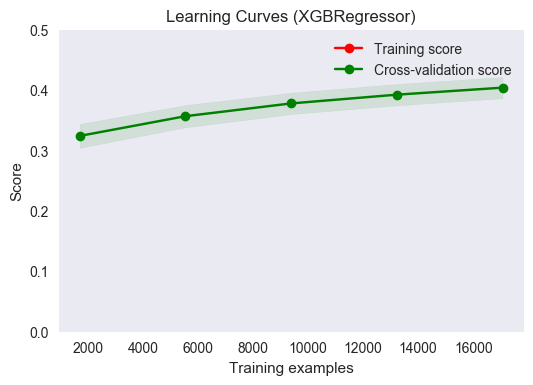

In [288]:
title = "Learning Curves (XGBRegressor)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
estimator = xgb.XGBRegressor(n_estimators=500, 
                             learning_rate=0.0597,
                             subsample=0.917,
                             colsample_bytree=0.631,
                             min_child_weight=3,
                             max_depth=6,
                             gamma=0.122,
                             seed=0,
                             silent=False)

plot_learning_curve(estimator, title, X_train, ylog_train, ylim=(0., 0.5), cv=cv, n_jobs=4)

The two mean scores lie directly on top of one another, indicating that the performance on the training and validation sets matches very closely, nearly perfectly, in fact.  Any error would be well-within the 1-sigma uncertainty bounds, indicated by the green solid area bisected by the mean scores.  It can be concluded that the model generalizes very well to unseen data.  The data appear to be approaching an asymptote, however this asymptote appears to be less than 0.5 even, indicating that housing price is not fully predictable given the feature set used.  The plot also indicates that performance could be improved with more training examples.

### Justification

To justify the use of this model, a simple comparison to the benchmark can be made.  A good place to start would be to repeat the above cross-validation on the benchmark model.

<module 'matplotlib.pyplot' from '/Users/jdinius/miniconda2/envs/ml_capstone/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

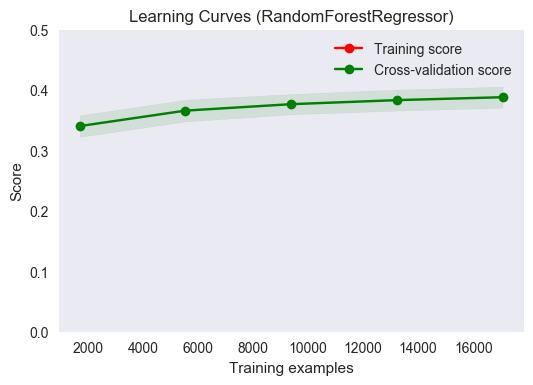

In [15]:
title = "Learning Curves (RandomForestRegressor)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
estimator = RandomForestRegressor(random_state=0, n_estimators=100, verbose=0)

plot_learning_curve(estimator, title, X_train, ylog_train, ylim=(0., 0.5), cv=cv, n_jobs=4)

The plot above shows subtle differences from the cross-validation plot for the tuned regressor.  First, there are some similarities.  Most notably, this regressor would perform better with more training results.  The asymptotic value that the data appears to be approaching is lower than that of the tuned regressor plot; the slope of the mean score line is flatter in this plot.  It appears as though maximum value of the R2 score for this regressor will occur for a smaller training sample size than the maximum obtained for the tuned regressor.  As in the tuned regressor case, the model generalizes well to unseen data.

The final solution is significant enough to solve the problem at hand.  The model gives reasonable performance given the complexity of the data and the minimal addition of features extracted from the raw data.  Practically, there is only so much training data that is available.  If more data were available, the model performance would be a little better, but nowhere near 1, as indicated by the cross-validation plot.  This solution is favorable over more complex solutions (such as stacked regressors) since it is easy to implement, easy to interpret, and provides adequate performance.

## V. Conclusion

### Free-Form Visualization

There is one table that hasn't been shown yet, but summarizes the analysis quite well.

**Regressor**|** R2 score**|** Improvement**|** Kaggle Public Score**|** Improvement**
-----|-----|-----|-----|-----
Random Forest| 0.39000| N/A| 0.41168| N/A
XGB Baseline| 0.40971| +0.050| 0.39276| -0.046
XGB Step 1| 0.41680| +0.069| 0.34795| -0.155 
XGB Step 2| 0.41756| +0.071| 0.34814| -0.154
XGB Step 3| 0.41667| +0.068| 0.34924| -0.152
XGB Step 4| 0.41689| +0.069| 0.35830| -0.130
XGB Step 5| 0.42211| +0.082| 0.33300| -0.191
XGB Step 6 (Final)| 0.42211| +0.082| 0.33300| -0.191

The above table shows improvement of each step over the benchmark.  The **Improvement** columns show the results of the relative improvement over the benchmark, computed as `(step*_score-benchmark_score)/benchmark_score`.  These columns can be interpreted, after multiplying by 100, as the percent relative change in the scores from the benchmark compared to each step.  The sought after trends are a positive change in R2 score and a negative change in the Kaggle public score.  The table shows that, through tuning, an 8% positive change in R2 score, along with a large 19% relative change in public score, were achieved.

### Reflection

A model was developed for predicting the sales price of properties within the Russian housing market based upon features provided by Sberbank, a Russian bank.  Plots were presented, and analyzed, showing trends in both micro- and macroeconomic features, and the relationship of these features to sales price.  Minimal feature engineering was performed on the dataset to provide a few additional, potentially important features.  A benchmark model based on an untuned random forest regressor was presented as an initial first cut at a solution.  Based upon previous analyses and their results, XGBoost was selected, and tuned, as the final solution for this problem.  XGBoost provided a nice framework to build upon since it requires minimal feature engineering and scaling to achieve best results.

Quite surprising was the fact that PCA didn't really improve performance, despite the high degree of multicollinearity observed in the data.  Perhaps naively, one would think that creating a new pseudofeature set that orthogonally spans the feature space would allow for greater predictive power of the underlying model.  However, the results seem to confirm the previous notion that decision trees are [insensitive to principal component reduction](https://stats.stackexchange.com/questions/141864/how-can-top-principal-components-retain-the-predictive-power-on-a-dependent-vari).

This project presented some difficulties in interpreting the data provided.  There were many features, and many of these features seemed very interrelated.  There was also much data missing.  Fortunately, there are good standalone packages within `sklearn` for dealing with such cases.  In the end, it was great that there exists a simple-to-use framework, XGBoost, that made working with the data very easy.

The final model fits expectations, and the process followed for tuning was very straightforward.  A similar process could be used for solving problems of a similar type: data analysis, data reduction/scaling, feature engineering, and regressor development are the common steps for any regression analysis.  Depending upon the data involved, it may not be necessary to use as strong a learner as XGBoost; a simple linear regressor may be adequate if the degree of nonlinearity in the target variable is low.  Given the data observed in the cross-validation plots and the amount of training data available, it seems that this model performs about as well as can be expected for a single regressor approach.

### Improvement

It would seem that better performance might be achieved if multiple learners were combined.  Some algorithms may achieve better performance for some regions in the feature space while others might perform better elsewhere.  The package [`mlxtend`](https://github.com/rasbt/mlxtend) provides a Python framework for doing stacked regression.  Stacked regression provides a way of combining multiple regressors into a single predictor, and has been shown to [work well in other Kaggle competitions](http://blog.kaggle.com/2016/12/27/a-kagglers-guide-to-model-stacking-in-practice/).  There is a trade-off here, though.  Typically, the added complexity comes with relatively modest improvements.  This added complexity may obscure any interpretation of the model; functional relationships between features and target variables may be more difficult to establish despite any observed increases in predictive power (i.e. R2 score).